# Imports
---

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, make_scorer, recall_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Data Loading, Exploration and Preprocessing
---

In [63]:
cols = ['Flyer_Miles/Year', 'Percent_Time_Gaming', 'IceCream_Liters/Week', 'Class']

In [64]:
train_dating = pd.read_csv(filepath_or_buffer="./datingData_training.txt", sep="\t", names=cols)
test_dating = pd.read_csv(filepath_or_buffer="./datingData_test.txt", sep="\t", names=cols)

train_dating_X = train_dating.iloc[:,-2::-1]
train_dating_Y = train_dating.iloc[:,-1]
test_dating_X = test_dating.iloc[:,-2::-1]
test_dating_Y = test_dating.iloc[:,-1]

dating_X = pd.concat([train_dating_X, test_dating_X], axis=0)
dating_Y = pd.concat([train_dating_Y, test_dating_Y], axis=0)

In [65]:
display(dating_X.head())
display(dating_Y.head())

,IceCream_Liters/Week,Percent_Time_Gaming,Flyer_Miles/Year
0,0.953952,8.326976,40920
1,1.673904,7.153469,14488
2,0.805124,1.441871,26052
3,0.428964,13.147394,75136
4,0.134296,1.669788,38344


0    largeDoses
1    smallDoses
2     didntLike
3     didntLike
4     didntLike
Name: Class, dtype: object

### Label Encoding and Standardizing

In [66]:
standard_scaler = StandardScaler()
label_encoder = LabelEncoder()

dating_X = pd.DataFrame(standard_scaler.fit_transform(dating_X), columns=cols[:len(cols)-1])
dating_Y = pd.Series(label_encoder.fit_transform(dating_Y), name='class')

display(dating_X.head())
display(dating_Y.head())
display(dating_Y.value_counts().head())

,Flyer_Miles/Year,Percent_Time_Gaming,IceCream_Liters/Week
0,0.245234,0.416602,0.331932
1,1.693857,0.139929,-0.872478
2,-0.054224,-1.206671,-0.345549
3,-0.811100,1.553092,1.891029
4,-1.404005,-1.152936,0.214553


0    1
1    2
2    0
3    0
4    0
Name: class, dtype: int64

class
0    342
2    331
1    327
Name: count, dtype: int64

### Visualizing feature distributions

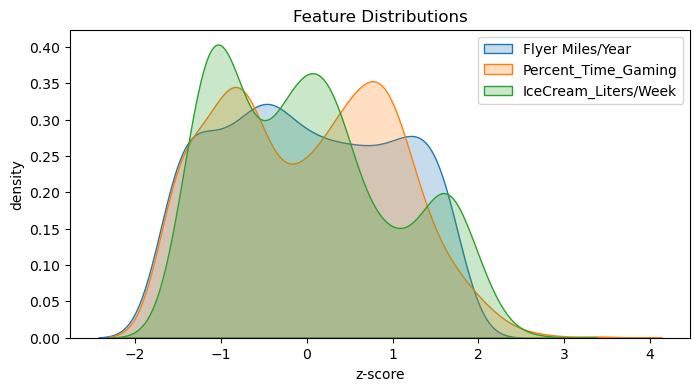

In [67]:
plt.figure(figsize=(8,4))

sns.kdeplot(dating_X['Flyer_Miles/Year'], fill=True, label='Flyer Miles/Year')
sns.kdeplot(dating_X['Percent_Time_Gaming'], fill=True, label='Percent_Time_Gaming')
sns.kdeplot(dating_X['IceCream_Liters/Week'], fill=True, label='IceCream_Liters/Week')
plt.title("Feature Distributions")
plt.xlabel("z-score")
plt.ylabel("density")
plt.legend()
plt.show()

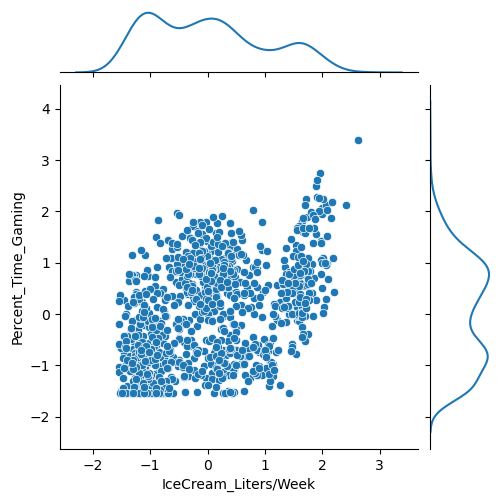

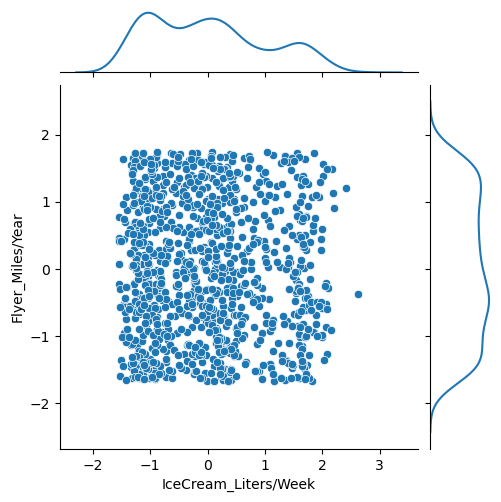

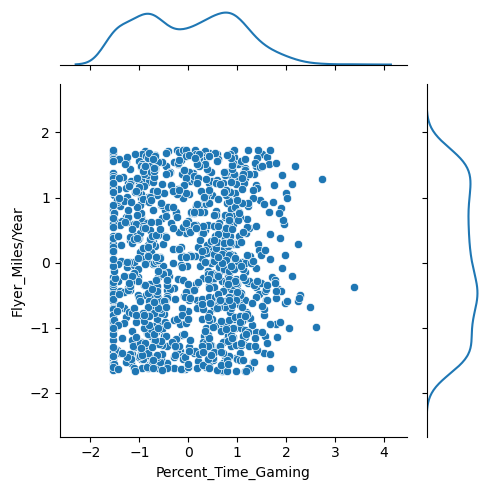

In [68]:
import itertools

for i, p in enumerate(itertools.combinations(cols[-2::-1], r=2)):
    g = sns.JointGrid(x=p[0], y=p[1], data=dating_X)
    g = g.plot(sns.scatterplot, sns.kdeplot)
    g.figure.set_size_inches(5, 5)
    g.set_axis_labels(p[0], p[1])
    g.ax_joint.set_xlim

plt.tight_layout()
plt.show()

### Useful Functions

In [69]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'recall' : make_scorer(recall_score, average='weighted')
    }
def cross_validation(X, Y, scoring, model, folds=10):
    cv_results = pd.DataFrame(cross_validate(model, X, Y, scoring=scoring, cv=folds),
                              index=np.arange(1,folds+1)).iloc[:,2:]
    cv_results.columns = ['accuracy', 'precision', 'f1-measure', 'recall']
    cv_results.index.name = 'trials'
    return cv_results

# Naive Bayes Classification (Assuming Gaussian Distribution)
---

Although some correlation can be observed between **gaming time** and **ice cream consumed**, Gaussian Naive Bayes remains a robust classification method due to the roughly normal feature distributions and no correlation between other feature pairs.

In [70]:
gnb = GaussianNB()

NaiveBayesResults = cross_validation(dating_X, dating_Y,
                                     scoring=scoring, model=gnb, folds=10)
NaiveBayesResults.mean()



accuracy      0.935000
precision     0.937537
f1-measure    0.934323
recall        0.935000
dtype: float64

# K-NN Classification
---

### Model Selection

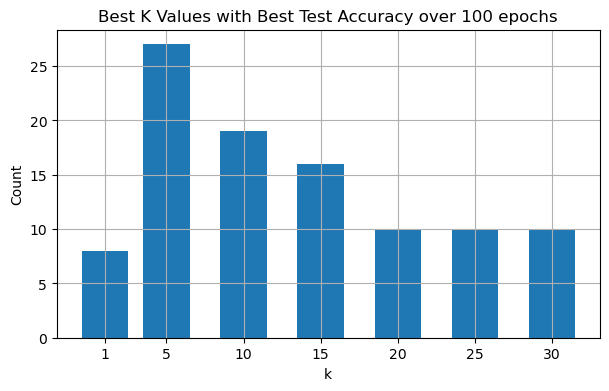

In [102]:

numNeighbors = [1, 5, 10, 15, 20, 25, 30]
bestk = defaultdict(int)

for epoch in range(100):
    testAcc = np.array([])
    for k in numNeighbors:
        X_train, X_test, Y_train, Y_test = train_test_split(dating_X, dating_Y,
                                                    test_size=0.1, shuffle=True,)    
        clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
        clf.fit(X_train, Y_train)
        Y_predTest = clf.predict(X_test)
        testAcc = np.append(testAcc, accuracy_score(Y_test, Y_predTest))
    bestkIndex = np.where(testAcc == max(testAcc))[0][0]
    bestk[numNeighbors[bestkIndex]] += 1
    
# Create a bar plot
keys = list(bestk.keys())
values = list(bestk.values())
plt.figure(figsize=(7,4))
plt.bar(keys, values, width=3)
plt.xlabel('k')
ticks = np.array([1])
plt.xticks(np.append(ticks, np.arange(5, 35, 5)))
plt.ylabel('Count')
plt.title('K Values with Best Test Accuracy over 100 epochs')
plt.grid()
plt.show()

### Validation

In [104]:
clf = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)

k_NN_Results = cross_validation(dating_X, dating_Y,
                                     scoring=scoring, model=clf, folds=10)
k_NN_Results.mean()



accuracy      0.952000
precision     0.953046
f1-measure    0.951742
recall        0.952000
dtype: float64